In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 
import metpy

# 2021.10.22
施工中，考虑进行2D DFT用于Ke的谱分析

## 数据读入

In [2]:
in_path = {}
case_number = "case0"
filename = "ke_all_8.5-11.5_km_vi_LambertConformal_" + case_number + ".nc"
in_path['vr'] = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi_proj/" + filename # VR
in_path['rcm'] = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi_proj/" + filename # RCM
in_path['era5i'] = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/ke_daily_vi_proj/" + filename # ERA5I

ke_sum = {}
for imod in ['vr', 'rcm', 'era5i']:
    ke_sum[imod] = xr.open_dataset(in_path[imod])['ke']

In [3]:
# 选取数据范围
sel_dict = {}
month_sel = [6,7,8]
year_sel  = [2005]
month_sel_cond  = ke_sum['vr'].Time.dt.month.isin(month_sel)
year_sel_cond   = ke_sum['vr'].Time.dt.year.isin(year_sel)

var_sel = {}
sel_dict['Time'] = month_sel_cond # & year_sel_cond
var_sel['vr']  = ke_sum['vr'].loc[sel_dict]
var_sel['rcm'] = ke_sum['rcm'].loc[sel_dict]
var_sel['era5i'] = ke_sum['era5i'].loc[sel_dict]

## DFTN

In [16]:
from scipy.fft import fftn
from scipy import signal

In [27]:
temp = signal.detrend(var_sel['vr'].values, axis = 1, type = 'linear')
temp = signal.detrend(temp, axis = 2, type = 'linear')

In [47]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
fftn_3d = {}
fftn_3d['vr'] = fftn(temp, axes = [1,2], norm = 'ortho')
# fftn_2d['rcm'] = fftn(var_sel['rcm'].values, type = 2, axes = [1,2], norm = 'ortho')
# fftn_2d['era5i'] = fftn(var_sel['era5i'].values, type = 2, axes = [1,2], norm = 'ortho')

# 添加维度参数
ntime = fftn_3d['vr'].shape[0]
nlat  = fftn_3d['vr'].shape[1]
nlon  = fftn_3d['vr'].shape[2]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

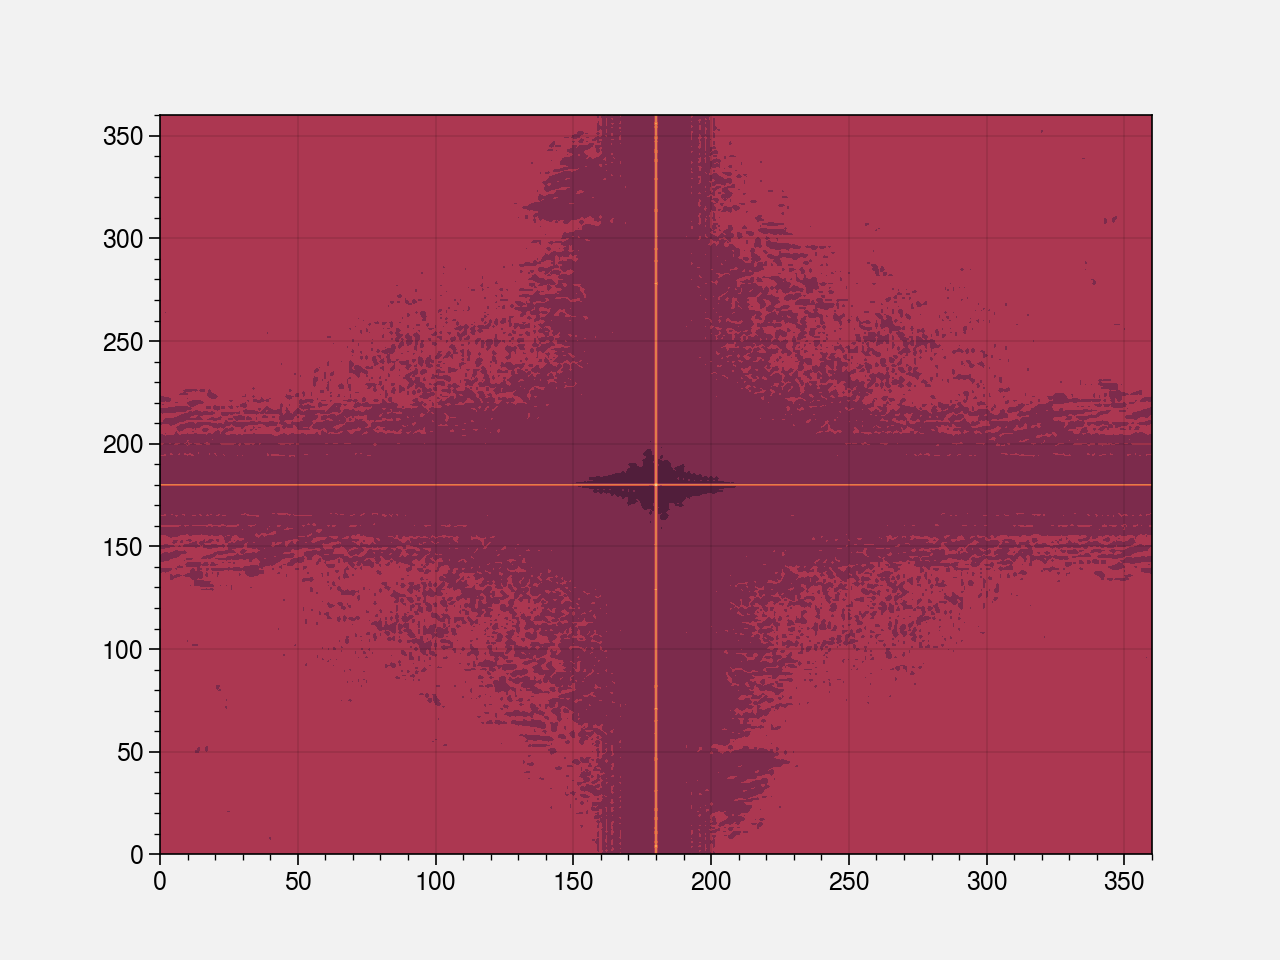

In [100]:
test = fftn_3d['vr'][0,:,:]
test = test / nlat / nlon
plt.contourf(np.log(np.abs(test)))

T = 1. / N
# xf freq

## 从2D谱方位角求和获得1D谱

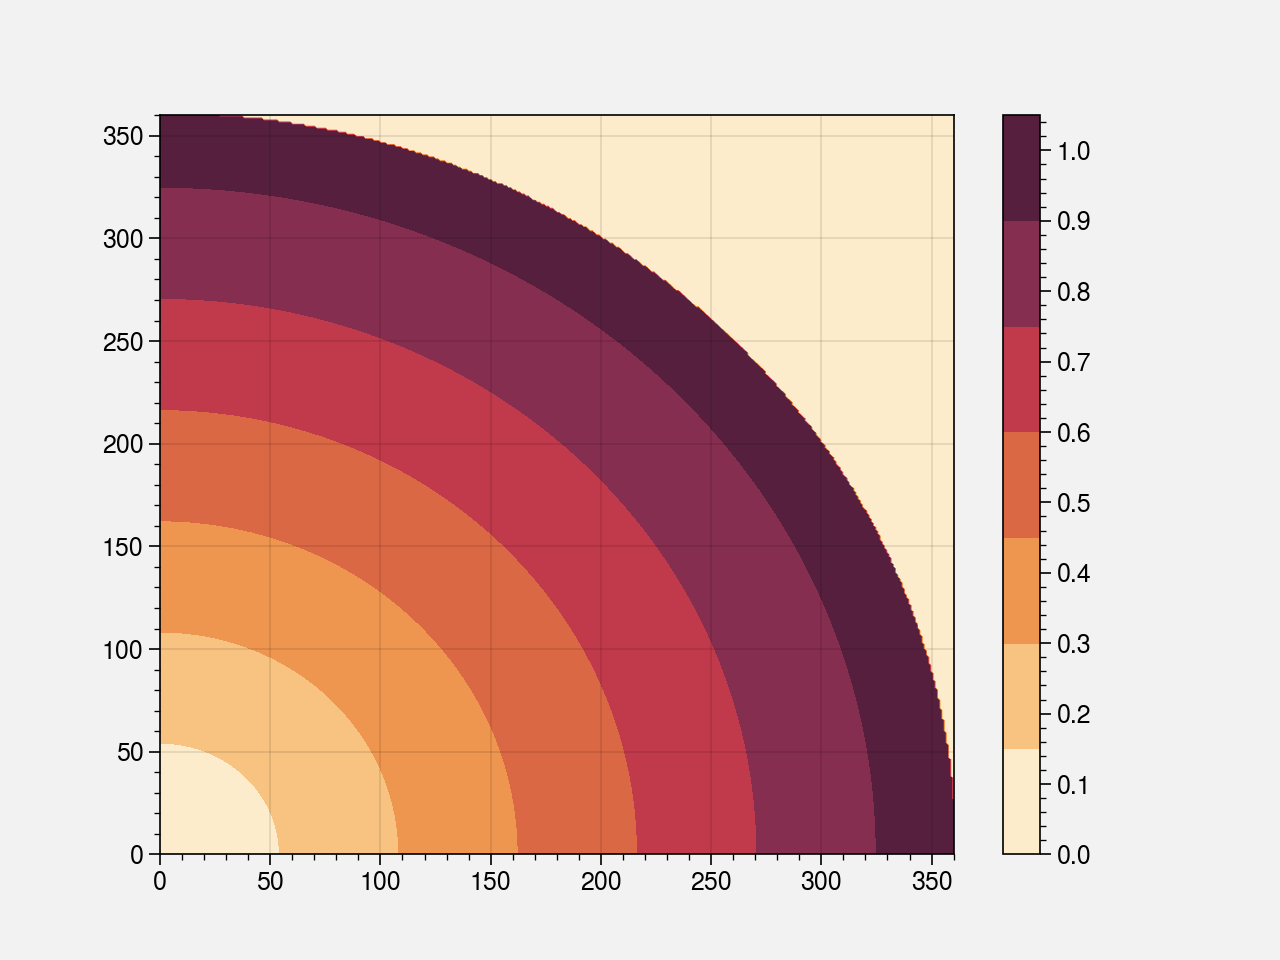

In [50]:
# 仿照denis2002进行2d alpha的预估
# nlat = 160 (miner)
# nlon = 280
Y, X     = np.ogrid[0:nlat, 0:nlon]
r        = np.hypot(X, Y).astype(np.int)
# 2D normalize wavenumber
alpha_2d =  np.empty(shape=r.shape)
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        alpha_2d[ilat, ilon] = np.sqrt( ilon**2/nlon**2 + ilat**2/nlat**2 )

alpha_1d = np.zeros(shape = int(np.min([nlat,nlon])))
for i in range(0, np.min([nlat, nlon]) ):
    alpha_1d[i] = i / np.min([nlat, nlon])
# 用于确定bins的1D谱
# alpha_1d = np.arange(1,nlat+1, 1) / nlat
# 去除掉alpha_2d中大于1的部分
alpha_2d = np.where(alpha_2d<=1, alpha_2d, 0)
plt.contourf(alpha_2d)
plt.colorbar(ticks = np.linspace(0,1,11))

In [51]:
N = np.min([nlat, nlon])

variance_1d = {}
variance_1d['vr'] =  np.zeros(shape=[nlat])
variance_1d['rcm'] =  np.zeros(shape=[nlat])
variance_1d['era5i'] =  np.zeros(shape=[nlat])

# 按照alpha进行bins，合并2d谱为1d谱，预先进行谱的时间平均

variance_2d = {} # 时间平均???如何平均，平均系数还是平均方差 是一个时次itime 的variance
variance_2d['vr'] = (fftn_3d['vr']).mean(axis=0)**2 /nlat /nlon
# variance_2d['rcm'] = (fftn_3d['rcm']).mean(axis=0)**2 /nlat /nlon
# variance_2d['era5i'] = (fftn_3d['era5i']).mean(axis=0)**2 /nlat /nlon


for i in range(0, np.min([nlat,nlon]) - 1):
    sel_index  = (alpha_2d >= alpha_1d[i]) & (alpha_2d < alpha_1d[i + 1])
    # mean or sum???
    # variance_1d['vr'][i] = variance_2d['vr'][sel_index].mean()
    # variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].mean()
    # variance_1d['era5i'][i] = variance_2d['era5i'][sel_index].mean()
    # 方位角积分
    variance_1d['vr'][i] = variance_2d['vr'][sel_index].sum()
    # variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].sum()
    # variance_1d['era5i'][i] = variance_2d['era5i'][sel_index].sum()


# 进行三点平滑
# variance_1d['vr']
variance_1d_filter = {}
variance_1d_filter['vr'] = np.empty(N//2)
# variance_1d_filter['rcm'] = np.empty(N//2)
# variance_1d_filter['era5i'] = np.empty(N//2)
# for i in range(0, N//2):
    # variance_1d_filter['vr'][i] = variance_1d['vr'][i*2] + 0.5 * variance_1d['vr'][i*2 - 1] + 0.5 * variance_1d['vr'][i*2 + 1]
    # variance_1d_filter['rcm'][i] = variance_1d['rcm'][i*2] + 0.5 * variance_1d['rcm'][i*2 - 1] + 0.5 * variance_1d['rcm'][i*2 + 1]
    # variance_1d_filter['era5i'][i] = variance_1d['era5i'][i*2] + 0.5 * variance_1d['era5i'][i*2 - 1] + 0.5 * variance_1d['era5i'][i*2 + 1]

<ipython-input-51-184ae742e584>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  variance_1d['vr'][i] = variance_2d['vr'][sel_index].sum()


## 绘图部分

<ipython-input-58-477bc20da4c1>:8: RuntimeWarning: divide by zero encountered in true_divide
  wavelen_1d = 2 * 10 / alpha_1d
<ipython-input-58-477bc20da4c1>:11: RuntimeWarning: invalid value encountered in sqrt
  axs.plot(xaxis, np.sqrt(variance_1d_filter['vr'][:]), label='vr', color='r')


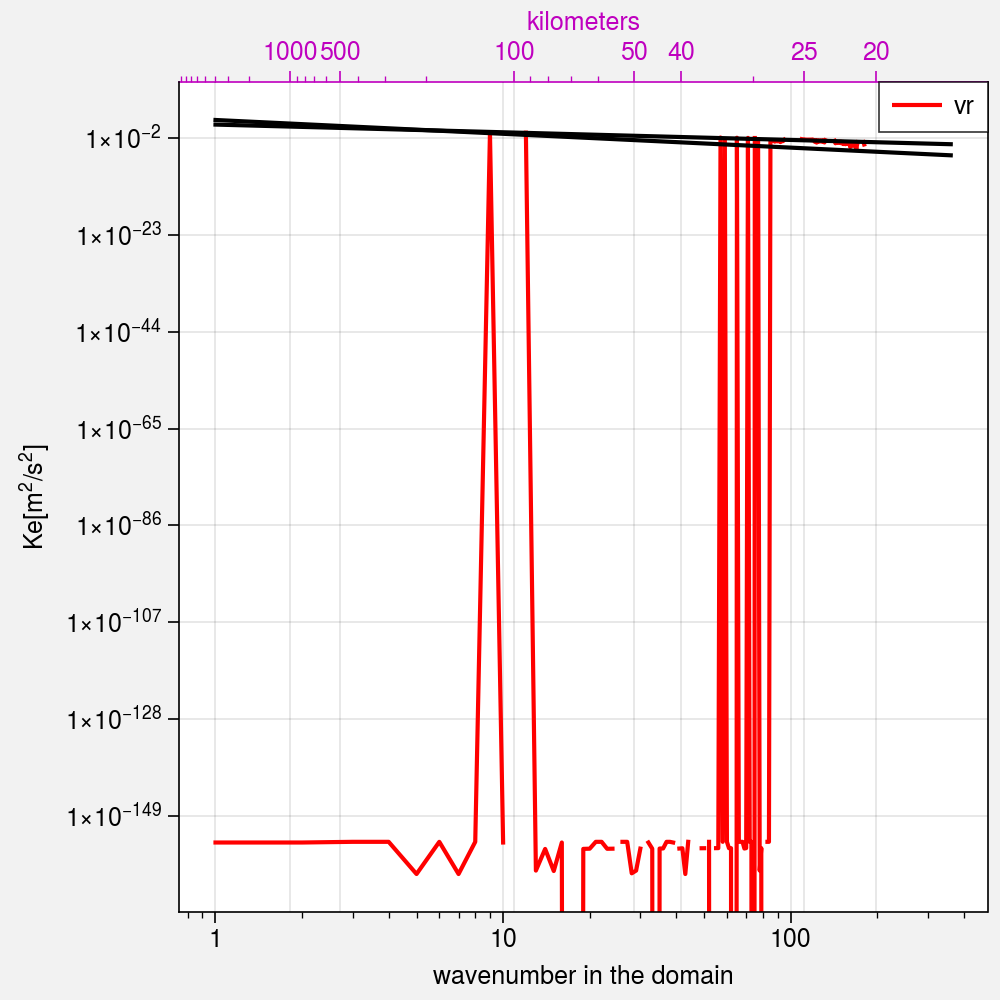

In [58]:
fig, axs = pplt.subplots(ncols = 1,nrows = 1,figsize=(5, 5))
# plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs.plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
xf = np.arange(1,nlon)
xaxis = xf[:N//2]
wavelen_1d = 2 * 10 / alpha_1d
# xaxis = wavelen_1d[:N//2]

axs.plot(xaxis, np.sqrt(variance_1d_filter['vr'][:]), label='vr', color='r')
# axs.plot(xaxis, np.sqrt(variance_1d_filter['rcm'][:]), label='rcm', color = 'b')
# axs.plot(xaxis, np.sqrt(variance_1d_filter['era5i'][:]), label='era5i', color = 'g')
# add reference line 
yref_synop = xf ** (-3.) * 1e2
yref_meso  = xf ** (-5./3) * 1e1
axs.plot(xf, yref_synop,color='k')
axs.plot(xf, yref_meso,color='k')

axs_ind = axs


axs_ind.set_xlabel('wavenumber in the domain')
axs_ind.set_ylabel(r'$Ke[m^2/s^2]$')
# axs_ind.set_aspect(0.3, 'box')
axs_ind.legend()

axs[0].dualx(
    # lambda x: np.sqrt((nlat**2 + nlon**2))*10*np.sqrt(2) / x,
    lambda x: 2*N*10/x,
    label='kilometers', color='m', gridcolor='m', grid = True,
    xlocator = (1000,500,100,50,40,25,20,10)
)

axs[0].format(
yscale = 'log',
xscale = 'log',
yformatter='sci',
# ylocator = (1e-3,1e-2,1e-1,1e0,1e1,1e2),
# ylim = (1e-4,1e3),
# xlim = (0,180)
)
# plt.savefig('./output_pic/ke_spectral_newproj_' + case_number + '.png', dpi=300, facecolor= "white")